In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import sys
sys.path.append('..')

features = pd.read_csv('model/features.csv', parse_dates=True, index_col=0) #load features as dataframe

In [2]:
#Create target variable "price"

price = features['resale_price']

In [3]:
#Check output of features
features.head()

,month,town,flat_type,floor_area_sqm,flat_model,resale_price,Storey,lease_commence_dt,remaining_lease_year
0,2012-03-01,ANG MO KIO,2 ROOM,45.0,Improved,250000.0,8.0,1986-01-01,72.836561
1,2012-03-01,ANG MO KIO,2 ROOM,44.0,Improved,265000.0,3.0,1980-01-01,66.835068
2,2012-03-01,ANG MO KIO,3 ROOM,68.0,New Generation,315000.0,8.0,1980-01-01,66.835068
3,2012-03-01,ANG MO KIO,3 ROOM,67.0,New Generation,320000.0,3.0,1984-01-01,70.835151
4,2012-03-01,ANG MO KIO,3 ROOM,67.0,New Generation,321000.0,8.0,1980-01-01,66.835068


In [4]:
#Create dummy variable and drop unncessary columns

dummies = ['town','flat_model']
final_df = features.drop(columns = ['month','resale_price','lease_commence_dt'])
final_df = pd.get_dummies(final_df,columns=dummies,drop_first=True)

In [5]:
# Map flat types to float values
# 5 room is 4.5 as the 5th room is smaller and optional
# No of rooms are official from hdb

final_df['flat_cat'] = final_df.flat_type.map({'2 ROOM':2, '3 ROOM':3, '4 ROOM':4,'5 ROOM': 4.5,
                                               '1 ROOM':1,'MULTI-GENERATION':5})

In [6]:
# Create a variable "is_executive"

final_df['Is_executive'] = final_df.flat_type.map({'EXECUTIVE': 1}) 
final_df[['Is_executive','flat_cat']]=final_df[['Is_executive','flat_cat']].replace(np.nan,0) #replace nan with 0
final_df = final_df.drop(columns = 'flat_type') # drop flat type here
final_df.sample(5) #sample 

,floor_area_sqm,Storey,remaining_lease_year,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,...,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,flat_cat,Is_executive
114942,59.0,5.0,54.752685,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.0
20899,95.0,2.0,89.997762,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,4.0,0.0
88355,60.0,14.0,63.084136,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3.0,0.0
22497,93.0,2.0,70.914550,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.0,0.0
40897,67.0,5.0,68.751603,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.0


In [7]:
# Prepare training and testing data

from sklearn.model_selection import train_test_split

X= final_df
y= price


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

## Feature Engineering

In [8]:
from sklearn.ensemble import ExtraTreesRegressor
sel=ExtraTreesRegressor(n_estimators=100)
sel.fit(X_train,y_train)

ExtraTreesRegressor()

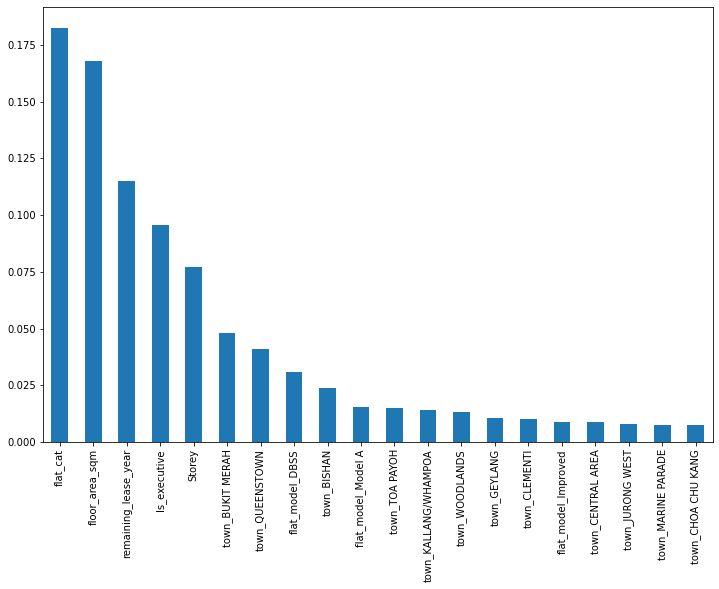

In [9]:
plt.figure(figsize = (12,8))
feat_impt = pd.Series(sel.feature_importances_, index=X.columns)
feat_impt.nlargest(20).plot(kind='bar')
plt.show()

## Random Forest Regressor

In [10]:
from sklearn.ensemble import RandomForestRegressor

rtree=RandomForestRegressor(n_estimators=300, random_state=42)

In [11]:
# train model
    
rtree.fit(X_train,y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [12]:
# test model

y_pred = rtree.predict(X_test)

In [14]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,max_error
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
rs = r2_score(y_test,y_pred)
print("Mean absolute error: " + str(mae)
     + "\nRMSE: " + str(rmse)
     + "\nR score: " +str(rs))        #print mae rmse and r2 score

Mean absolute error: 27553.14383956683
RMSE: 38654.46288236293
R score: 0.9290879513167196


In [15]:
# Overfit check
print(rtree.score(X_train,y_train))
print(rtree.score(X_test,y_test))

0.9859341742709792
0.9290879513167196


## Hyper-Parameter tuning with XGBoost and halvinggridsearchCV

In [16]:
#Using halving grid
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
params = {
        'colsample_bytree': [0.5, 0.7,0.9],
        'max_depth': [7,9,11],
        'n_estimators' : [300, 400, 500, 600],
        'subsample' : [0.7,0.8,0.9],
        'objective': ['reg:squarederror']
    
        }

In [17]:
# Use halving grid search on xgboost

from xgboost import XGBRegressor
import time
xgbooster = XGBRegressor()
gridxg = HalvingGridSearchCV(
                    estimator=xgbooster,
                    param_grid=params,
                    cv=5,
                    n_jobs=6,
                    verbose=1,
                    min_resources='exhaust',
                    error_score ='raise'
)
%time gridxg.fit(X_train,y_train)

gridxg.best_params_

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1949
max_resources_: 157923
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 1949
Fitting 5 folds for each of 108 candidates, totalling 540 fits
----------
iter: 1
n_candidates: 36
n_resources: 5847
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 2
n_candidates: 12
n_resources: 17541
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 52623
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 157869
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 9min 40s


{'colsample_bytree': 0.5,
 'max_depth': 7,
 'n_estimators': 400,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [29]:
# Predict values with model

xgb_model = XGBRegressor(
                objective='reg:squarederror',
                colsample_bytree=0.5,
                learning_rate=0.1,
                max_depth=12,
                n_estimators=500,
                subsample=0.9
                )
%time xgb_model.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)],verbose=False)

y_pred2 = xgb_model.predict(X_test)
mae2 = mean_absolute_error(y_test,y_pred2)
rmse2 = np.sqrt(mean_squared_error(y_test,y_pred2))
rs2 = r2_score(y_test,y_pred2)

# Print scores

print("Mean absolute error: " + str(mae2)
     + "\nRMSE: " + str(rmse2) +
     "\nr2 Score: " + str(rs2))

Wall time: 23.6 s
Mean absolute error: 26024.038357041994
RMSE: 36037.47840847168
r2 Score: 0.9383646967649487


In [30]:
#Overfit check

print(xgb_model.score(X_train,y_train))

print(xgb_model.score(X_test,y_test))

0.9623734455756948
0.9383646967649487


<ipython-input-31-73f78c501c15>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


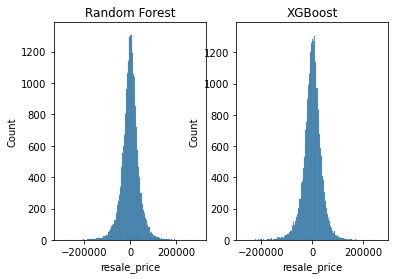

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2) #print the histplot of XGBoost and Random forest pred values for comparison
ax1.set_title('Random Forest')
ax2.set_title('XGBoost')
sns.histplot(y_pred-y_test,ax=ax1,)
sns.histplot(y_pred2-y_test,ax=ax2)
fig.show()

In [32]:
# Prepare values to concat

df_ypred = pd.DataFrame(y_pred, columns = ['Random Forest'])
df_ypred2 = pd.DataFrame(y_pred2, columns =['XGBRegressor'])
df_ytest = pd.DataFrame(y_test, columns = ['resale_price'])
df_ypred.reset_index(drop=True, inplace=True)
df_ypred2.reset_index(drop=True, inplace=True)
df_ytest.reset_index(drop=True, inplace=True)

In [33]:
# Round values

df_ypred =df_ypred.round(0)
df_ypred2=df_ypred2.round(0)

In [34]:
# Concat into new list of y values

concat_list = [df_ytest,df_ypred,df_ypred2]
df_y = pd.concat([df_ytest,df_ypred,df_ypred2], axis=1)
df_y

,resale_price,Random Forest,XGBRegressor
0,350000.0,323726.0,353375.0
1,870000.0,866839.0,846428.0
2,428000.0,481109.0,464422.0
3,280000.0,324156.0,341826.0
4,290000.0,291339.0,289215.0
...,...,...,...
39476,755888.0,677113.0,716402.0
39477,245000.0,262322.0,259320.0
39478,550000.0,467468.0,449598.0
39479,270000.0,260637.0,257809.0


In [35]:
# This finds the absolute biggest % difference between the models 

maxdiffrt = ((df_y['resale_price']-df_y['Random Forest'])/(df_y['resale_price'])).abs().max()
maxdiffxgb =((df_y['resale_price']-df_y['XGBRegressor'])/(df_y['resale_price'])).abs().max()

print("Max difference in price for random forest is : " + str(maxdiffrt)
     +"\nMax difference in price for XGB is : " + str(maxdiffxgb))

Max difference in price for random forest is : 0.675880217785844
Max difference in price for XGB is : 0.5130495867768595


In [36]:
# This finds and prints the row with the biggest % difference

rtdiffindex = ((df_y['resale_price']-df_y['Random Forest'])/(df_y['resale_price'])).abs().idxmax()
xgbdiffindex =((df_y['resale_price']-df_y['XGBRegressor'])/(df_y['resale_price'])).abs().idxmax()
print("Row with greatest difference:")
print(df_y.loc[[rtdiffindex]])
print(df_y.loc[[xgbdiffindex]])

Row with greatest difference:
       resale_price  Random Forest  XGBRegressor
31477      275500.0       461705.0      413138.0
       resale_price  Random Forest  XGBRegressor
17802      242000.0       340100.0      366158.0
